# Лабораторная работа 4. Кластеризация"

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

In [1]:
import kagglehub

path = kagglehub.dataset_download("prince2004patel/iti-student-dropout-synthetic-dataset")

print("Path to dataset files:", path)

f:\ml\LAB4\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\vaind\.cache\kagglehub\datasets\prince2004patel\iti-student-dropout-synthetic-dataset\versions\1


<h3>Описание датасета</h3>
Этот набор данных содержит 7 ключевых агрономических признаков, характеризующих почвенные условия и климатические параметры, а также целевую переменную — тип подходящей культуры. Он был синтетически сгенерирован для исследований и построения моделей машинного обучения в области точного земледелия с целью рекомендации оптимальных культур для выращивания на основе почвенно-климатических условий.

Набор данных включает следующие признаки:

1. **Почвенные питательные вещества**  
   - азот (`N`): концентрация азота в почве (мг/кг) — числовой, диапазон зависит от типа почвы  
   - фосфор (`P`): концентрация фосфора в почве (мг/кг) — числовой  
   - калий (`K`): концентрация калия в почве (мг/кг) — числовой  

2. **Климатические условия**  
   - температура (`temperature`): средняя температура почвы (°F) — числовой, оптимальный диапазон для биоактивности: 50–75°F  
   - влажность (`humidity`): относительная влажность воздуха (%) — числовой  
   - pH почвы (`ph`): показатель кислотности/щелочности почвы — числовой (кислая: pH < 7; нейтральная: pH = 7; щелочная: pH > 7)  
   - осадки (`rainfall`): годовое количество осадков (мм) — числовой, варьируется в зависимости от региона  

3. **Целевая переменная**  
   - культура (`label`): категориальный — тип рекомендуемой сельскохозяйственной культуры (например: рис, пшеница, кукуруза, соя, кофе, чай и др.), определяемый на основе оптимального сочетания почвенных и климатических условий  

Этот датасет предназначен для задач классификации в агротехнологиях: на основе анализа текущих параметров почвы и климата модель предсказывает наиболее подходящую культуру для посева, способствуя повышению урожайности, рациональному использованию ресурсов и устойчивому развитию сельского хозяйства — особенно в условиях растущего спроса на продовольствие и изменения климата.

<h3>Импорт библиотек</h3>

In [33]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    rand_score, adjusted_rand_score, jaccard_score,
    adjusted_mutual_info_score
)
from scipy.spatial.distance import cdist

<h3>Описательный анализ</h3>

In [13]:
dataset_path = r"F:\ml\datasets\Crop_recommendation.csv"
df = pd.read_csv(dataset_path)

print("Первые строки")
print(df.head())
print("\nИнформация о данных")
print(df.info())

Первые строки
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
mem

In [14]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [15]:
df = df[(df != 0).all(axis=1)]

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

print("Числовые признаки:", numeric_cols)


Числовые признаки: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


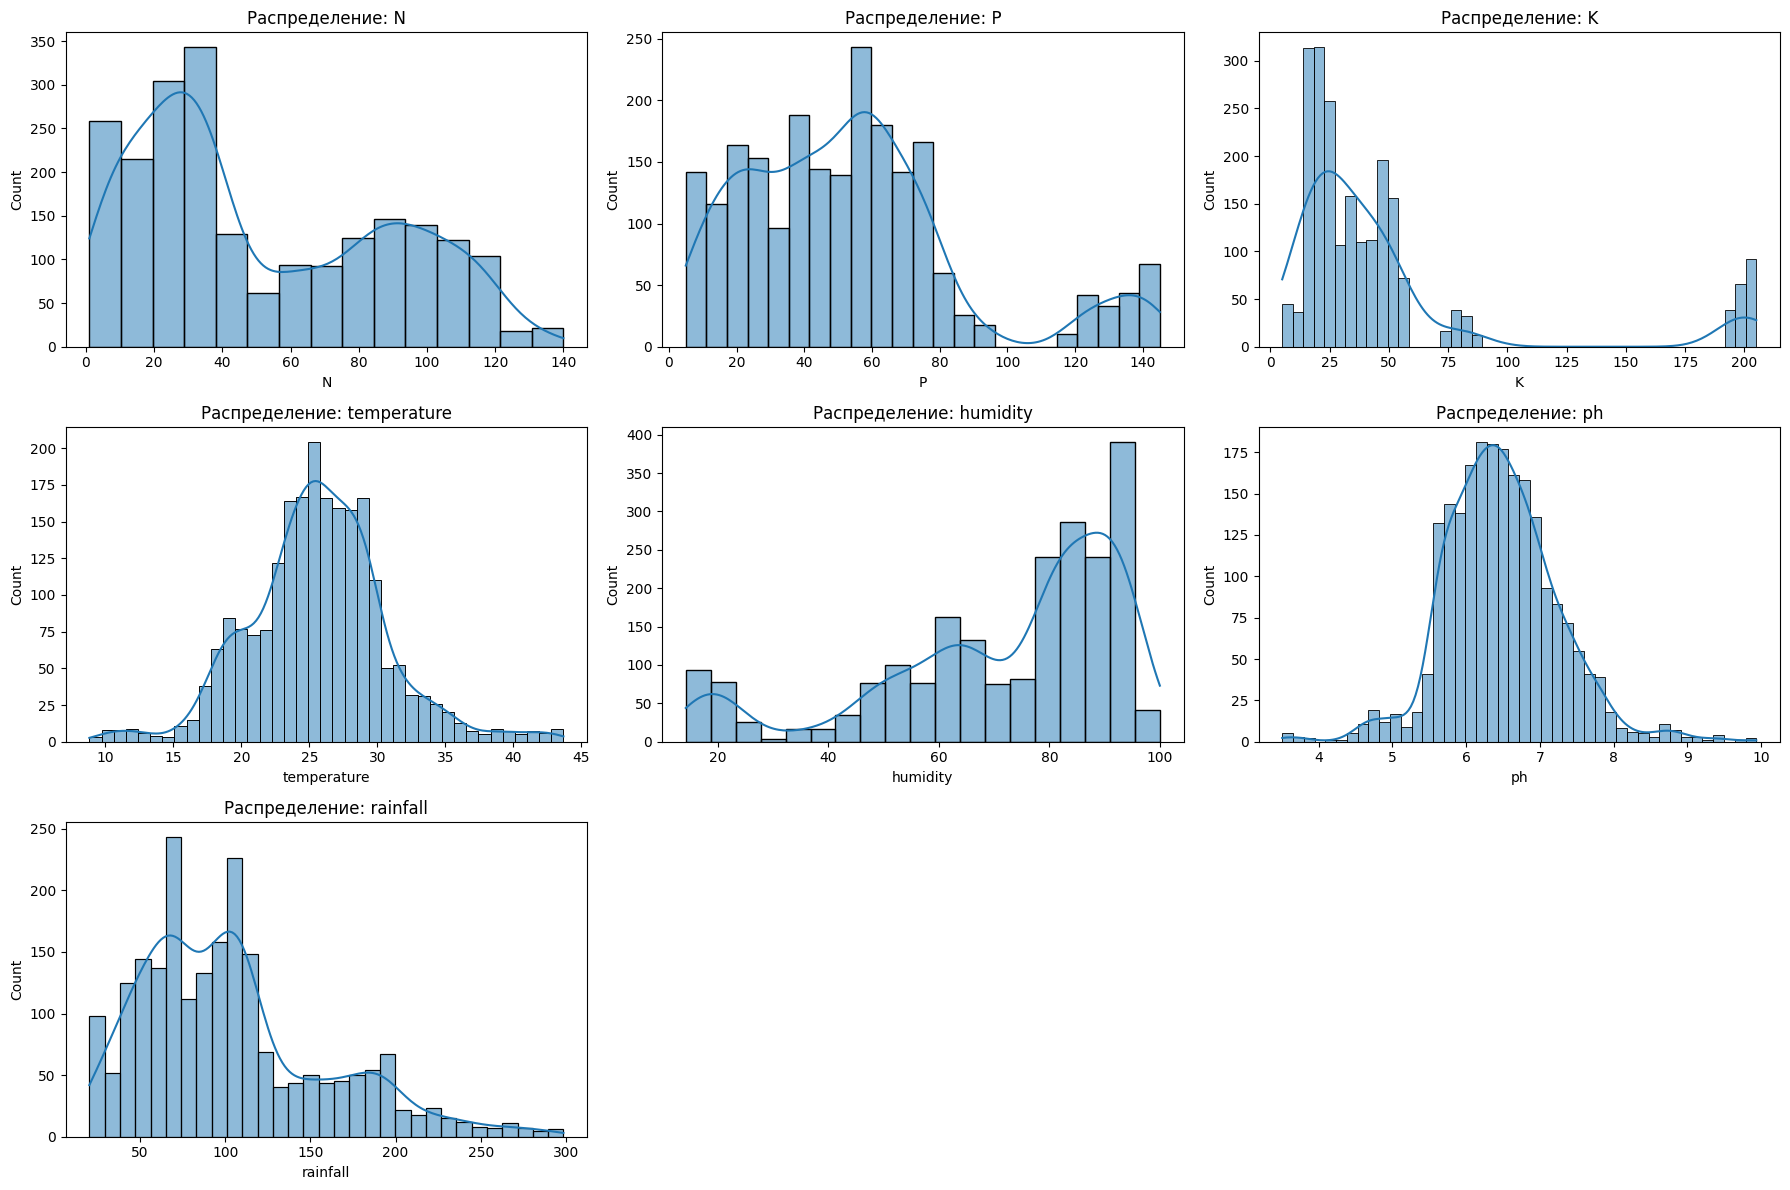

In [17]:
num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_numeric[col], kde=True)
    plt.title(f"Распределение: {col}")

plt.tight_layout()
plt.show()

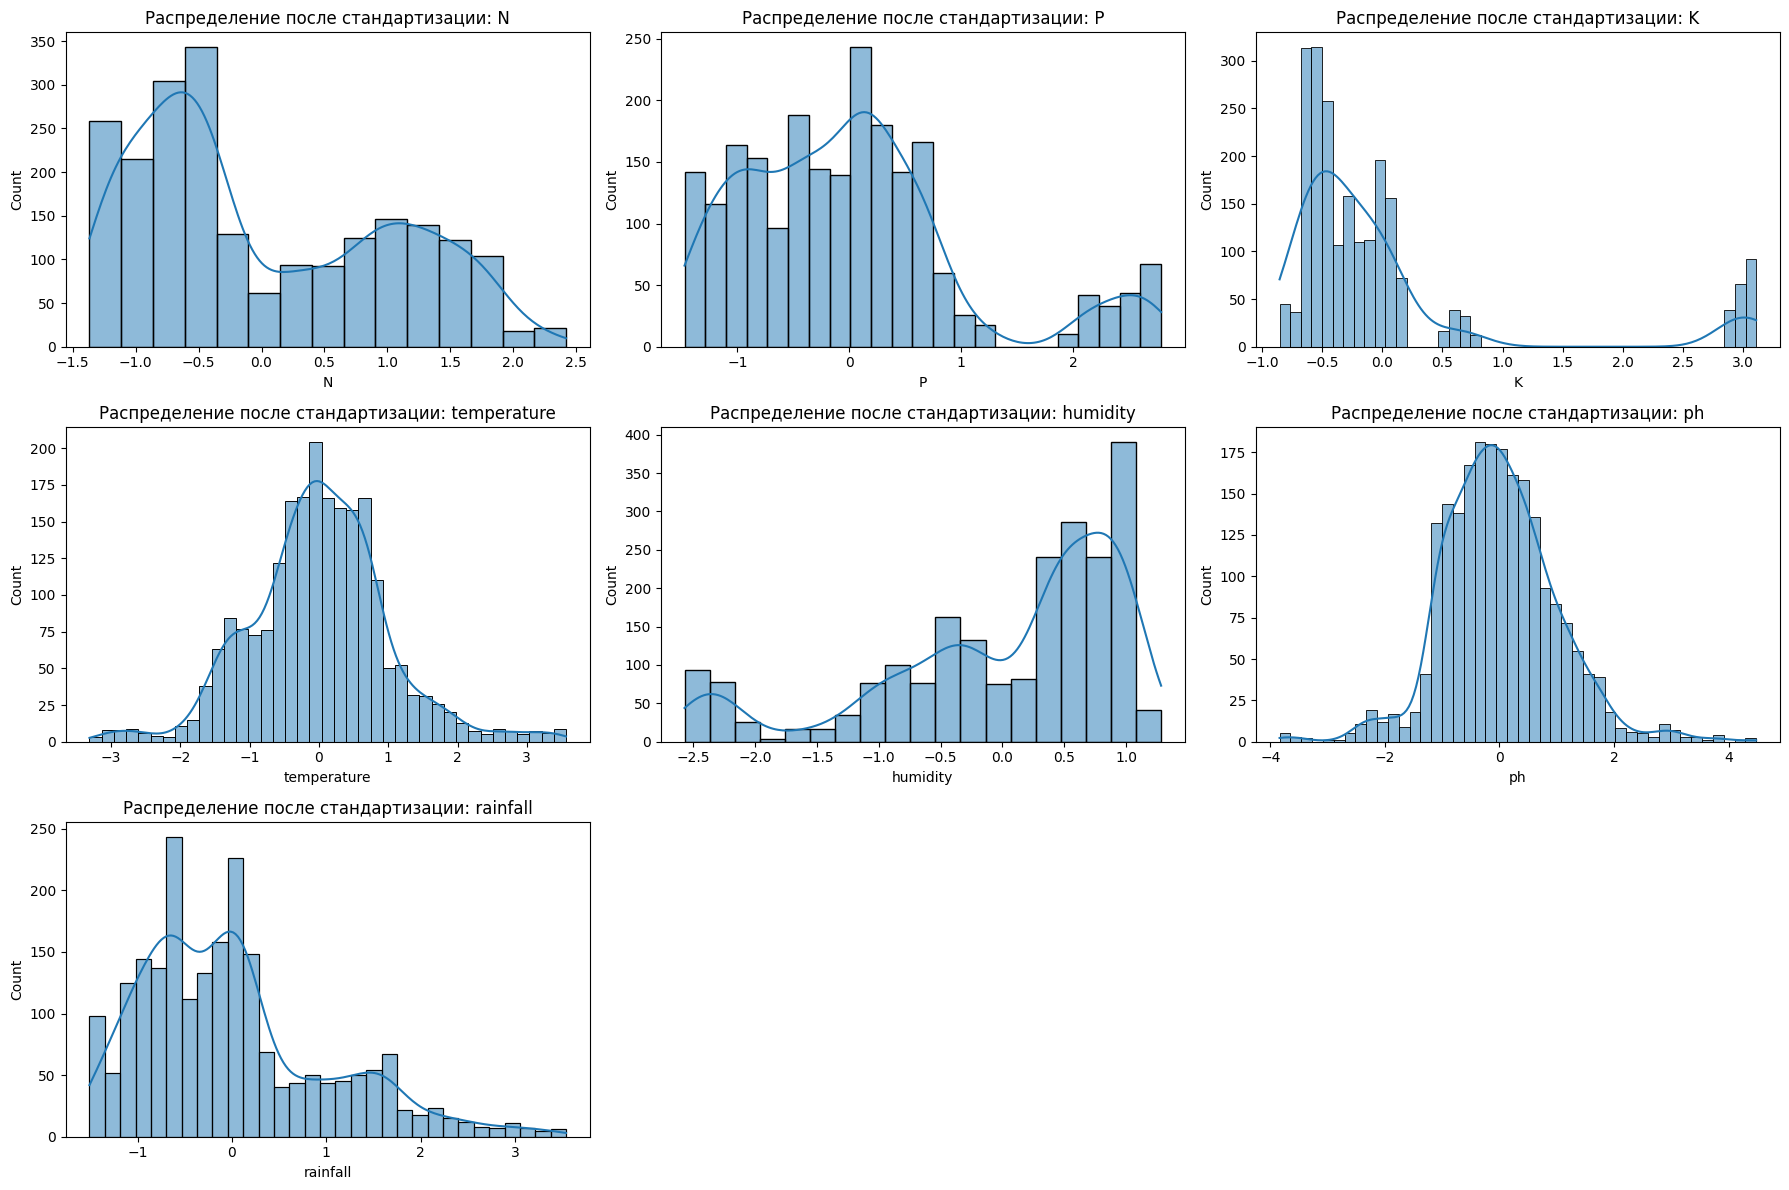

In [18]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_scaled[col], kde=True)
    plt.title(f"Распределение после стандартизации: {col}")

plt.tight_layout()
plt.show()

<b>Вывод:</b> После стандартизации все числовые признаки были приведены к единой шкале с нулевым средним и единичным стандартным отклонением, что явно отражено на графиках распределений - формы гистограмм остались неизменными, но их положение и масштаб по оси X кардинально изменились, что подтверждает корректное применение StandardScaler. Этот метод выбран потому, что он оптимален для признаков с приблизительно нормальным распределением, не требует предположений о границах данных и менее чувствителен к выбросам по сравнению с MinMaxScaler.

<Figure size 2000x2000 with 0 Axes>

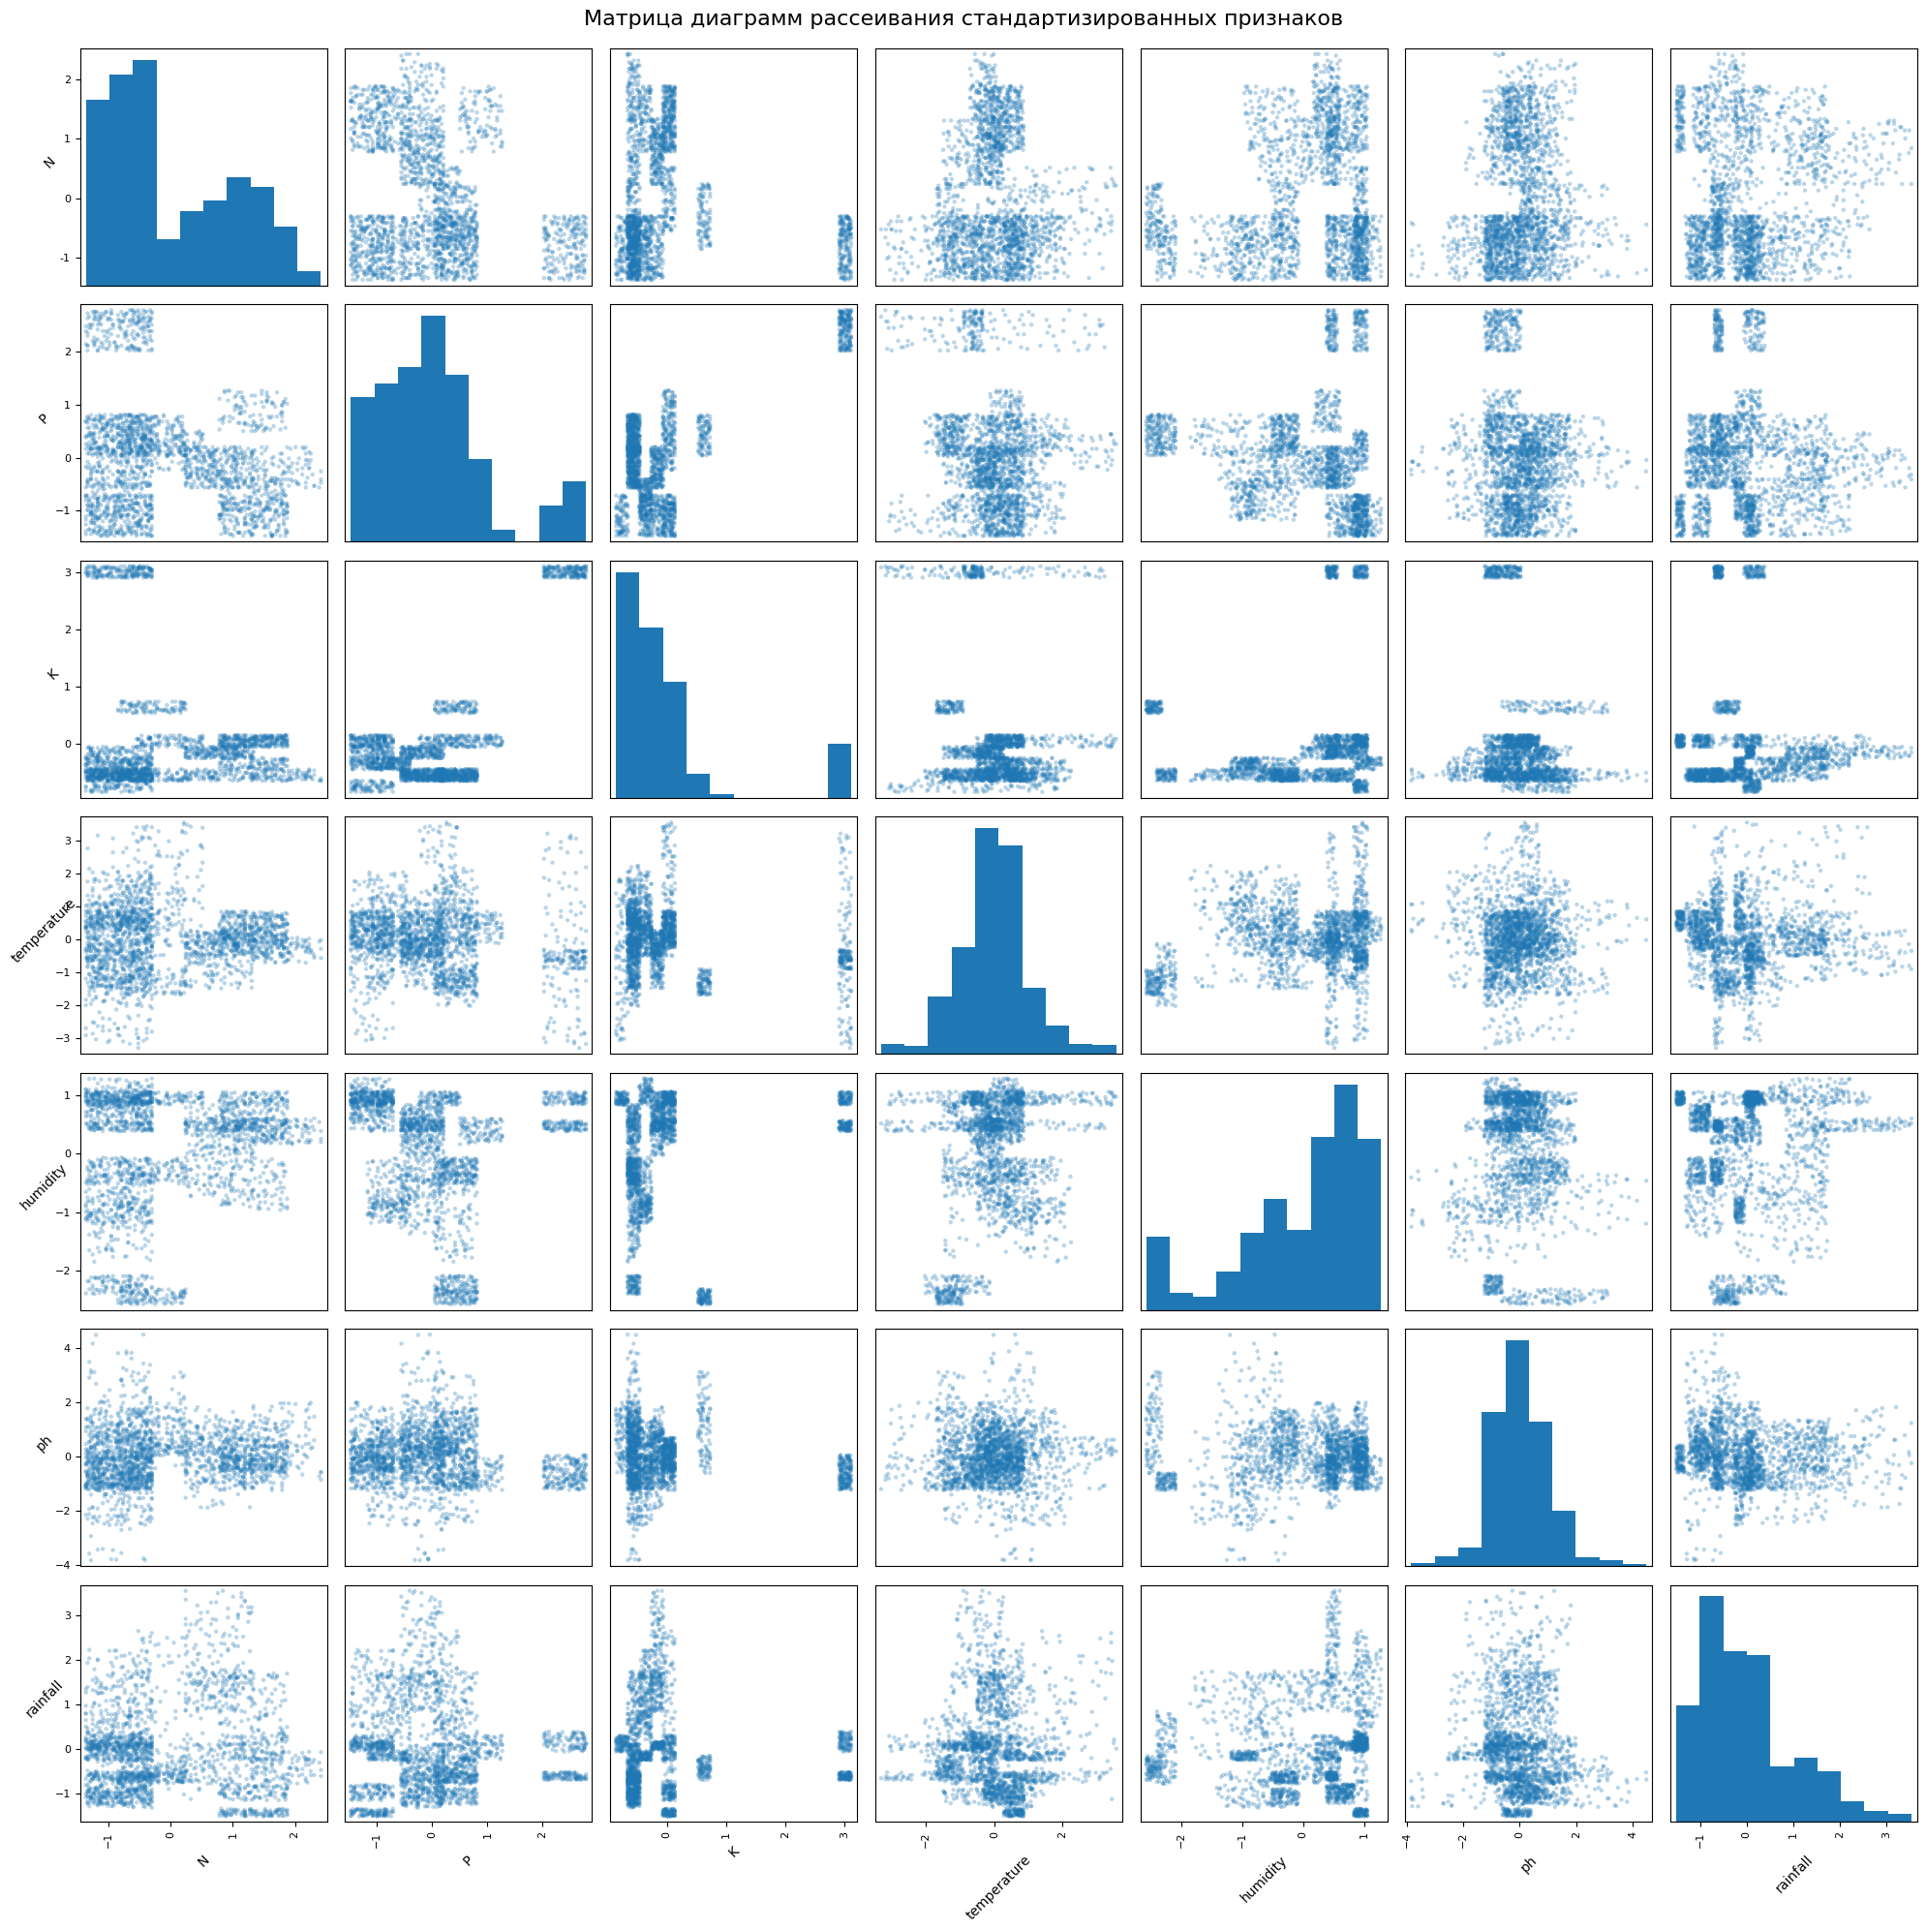

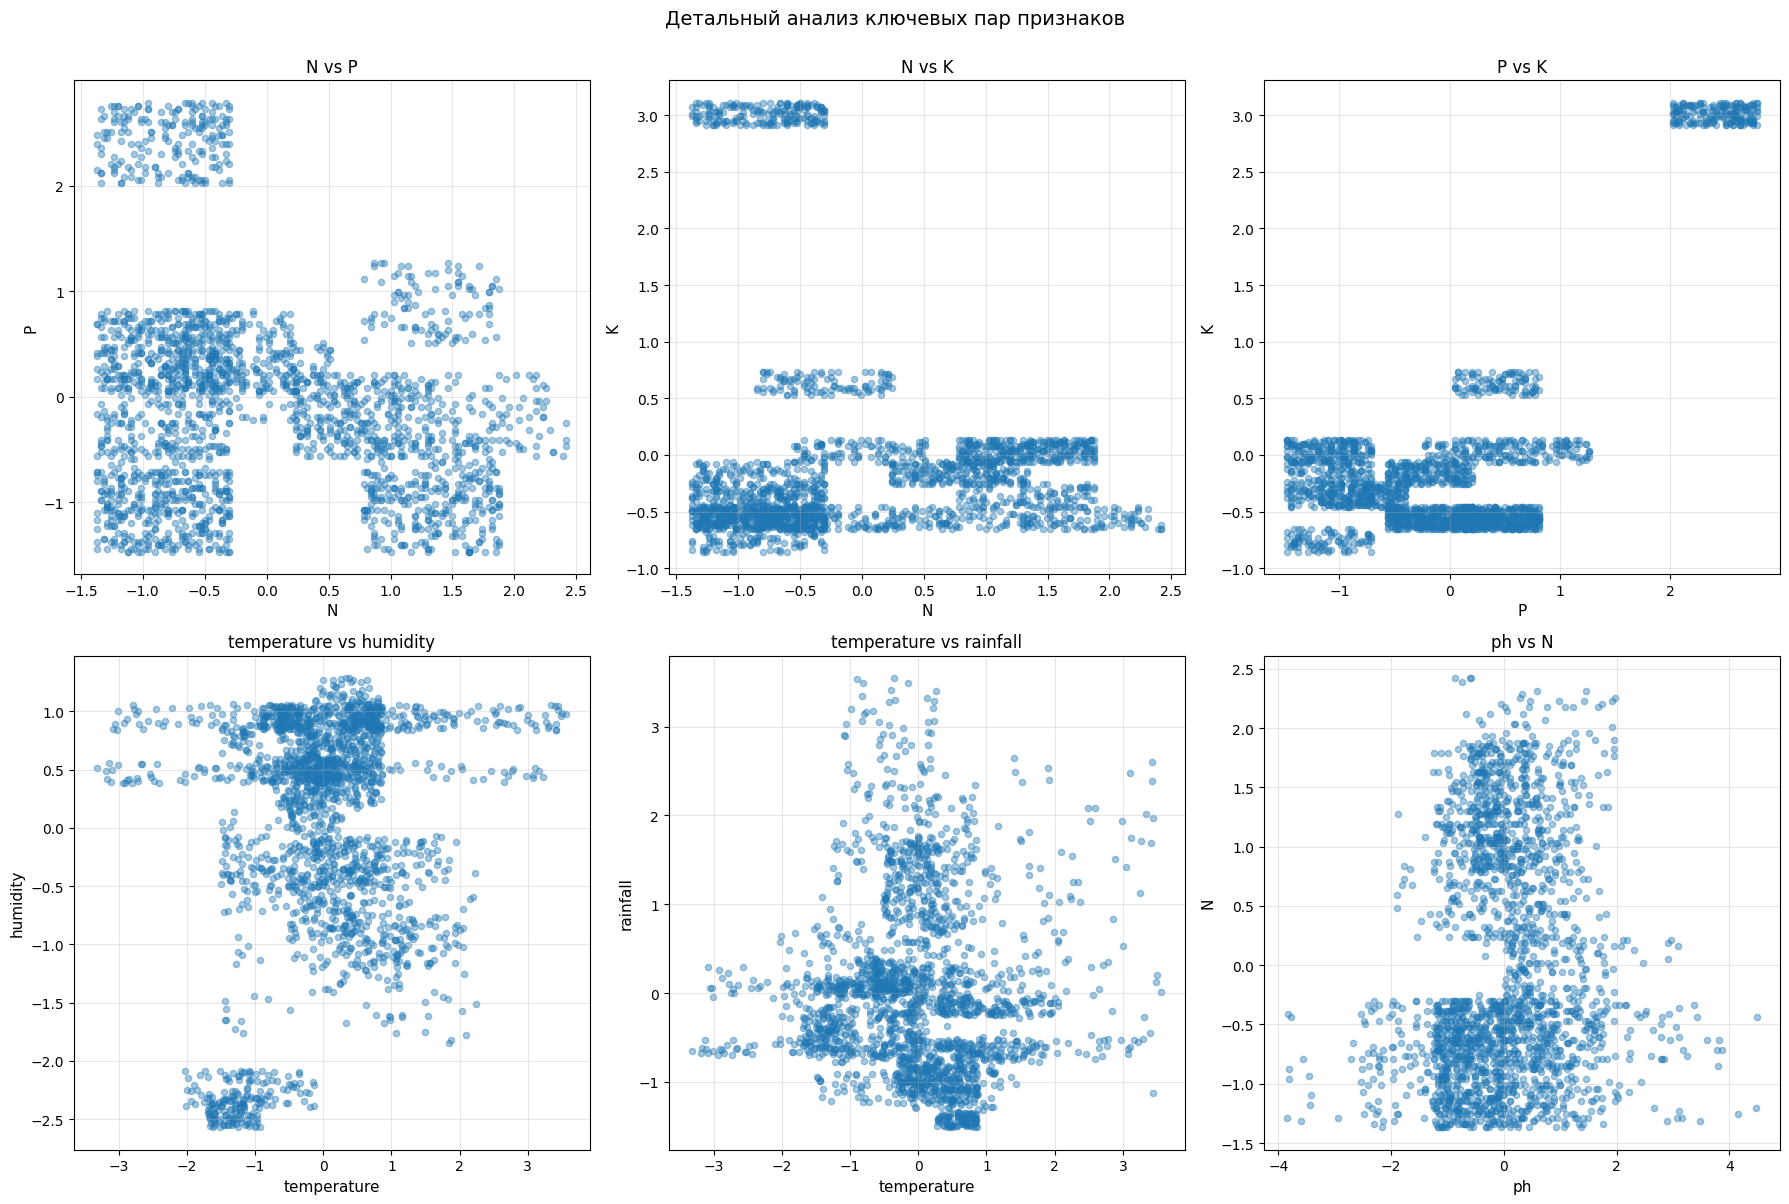

In [20]:
numeric_cols =['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

plt.figure(figsize=(20, 20))
scatter_matrix = pd.plotting.scatter_matrix(
    df_scaled[numeric_cols],
    alpha=0.3,
    figsize=(20, 20),
    diagonal='hist',
    marker='o',
    s=10
)
 
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, rotation=45)

plt.suptitle('Матрица диаграмм рассеивания стандартизированных признаков', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

interesting_pairs = [
    ('N', 'P'),
    ('N', 'K'),
    ('P', 'K'),
    ('temperature', 'humidity'),
    ('temperature', 'rainfall'),
    ('ph', 'N')
]

for idx, (feature1, feature2) in enumerate(interesting_pairs):
    axes[idx].scatter(df_scaled[feature1], df_scaled[feature2], 
                      alpha=0.4, s=20)
    axes[idx].set_xlabel(feature1, fontsize=11)
    axes[idx].set_ylabel(feature2, fontsize=11)
    axes[idx].set_title(f'{feature1} vs {feature2}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Детальный анализ ключевых пар признаков', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

<b>Вывод:</b> Визуальный анализ матрицы диаграмм рассеивания показывает, что данные не содержат четко выраженных кластеров; наблюдается единое облако точек с плавными переходами и отсутствием резких границ между группами. Некоторые пары признаков демонстрируют слабую или умеренную линейную зависимость (например, `temperature` и `humidity`, `N` и `P`), в то время как другие — практически независимы или имеют нелинейную связь (например, `ph` с любыми другими признаками). Гистограммы распределений указывают на наличие выбросов и асимметрии, особенно для `K` и `rainfall`.

Структура данных подходит для методов кластеризации, основанных на центроидах, таких как K-Means, который сможет выделить группы на основе средних значений и расстояний. Также целесообразно применить Gaussian Mixture Models для учета вероятностных распределений и перекрытия групп, а также иерархическую кластеризацию для визуального определения оптимального числа кластеров через дендрограмму. Метод DBSCAN, требующий плотных областей и ясных границ, в данном случае будет неэффективен из-за равномерного распределения точек и отсутствия разреженных зон.

In [21]:
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df_scaled[numerical_features].values
k_range = range(2, 11)

kmeans_inertia = []
kmeans_silhouette = []
kmeans_davies_bouldin = []

hierarchical_silhouette = []
hierarchical_davies_bouldin = []

gmm_bic = []
gmm_aic = []
gmm_silhouette = []

print("\nВычисление метрик для различных значений k...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_silhouette.append(silhouette_score(X, kmeans_labels))
    kmeans_davies_bouldin.append(davies_bouldin_score(X, kmeans_labels))
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_bic.append(gmm.bic(X))
    gmm_aic.append(gmm.aic(X))
    gmm_silhouette.append(silhouette_score(X, gmm_labels))
    
    print(f"k={k}: K-Means Silhouette={kmeans_silhouette[-1]:.3f}, "
          f"GMM Silhouette={gmm_silhouette[-1]:.3f}")


Вычисление метрик для различных значений k...

k=2: K-Means Silhouette=0.418, GMM Silhouette=0.327
k=3: K-Means Silhouette=0.252, GMM Silhouette=0.251
k=4: K-Means Silhouette=0.255, GMM Silhouette=0.241
k=5: K-Means Silhouette=0.292, GMM Silhouette=0.266
k=6: K-Means Silhouette=0.304, GMM Silhouette=0.267
k=7: K-Means Silhouette=0.332, GMM Silhouette=0.312
k=8: K-Means Silhouette=0.326, GMM Silhouette=0.319
k=9: K-Means Silhouette=0.331, GMM Silhouette=0.302
k=10: K-Means Silhouette=0.347, GMM Silhouette=0.328


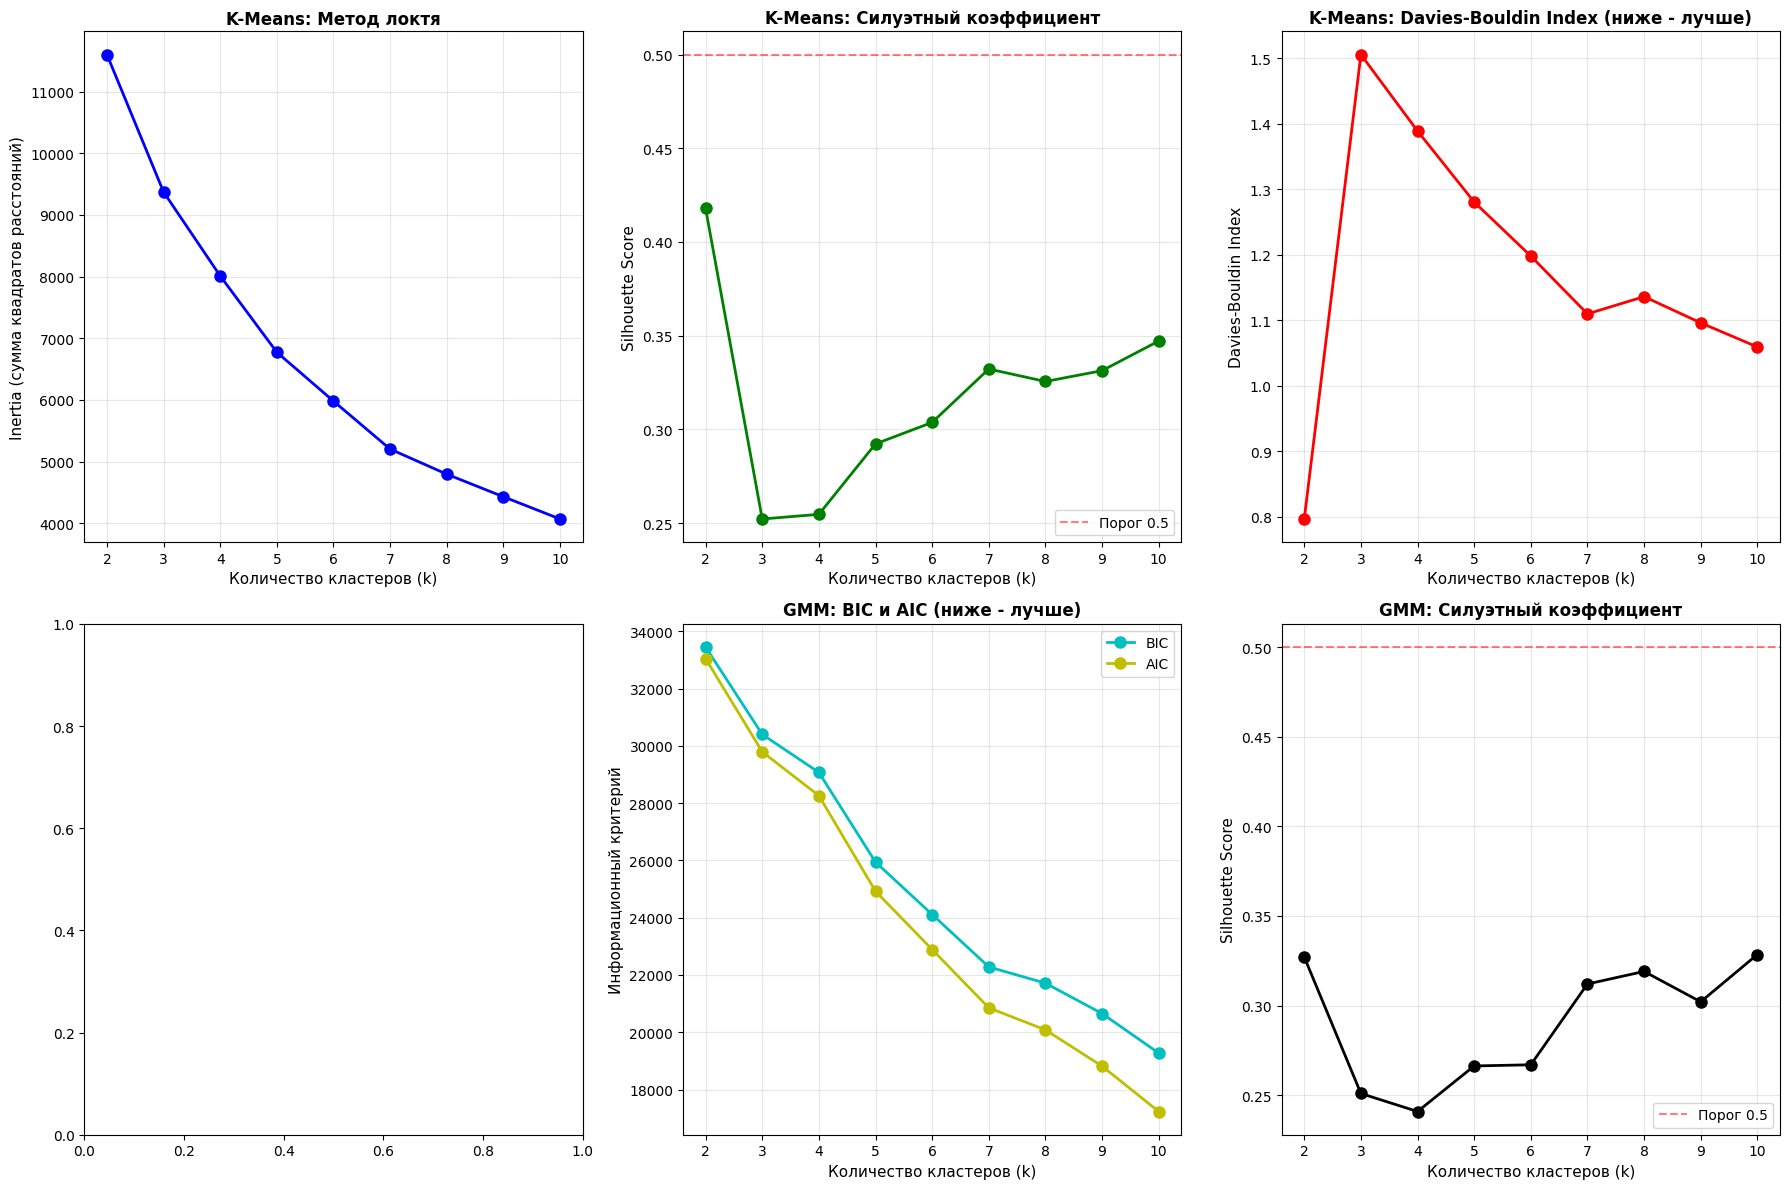

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# K-Means: Метод локтя
axes[0, 0].plot(k_range, kmeans_inertia, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 0].set_ylabel('Inertia (сумма квадратов расстояний)', fontsize=11)
axes[0, 0].set_title('K-Means: Метод локтя', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# K-Means: Силуэтный анализ
axes[0, 1].plot(k_range, kmeans_silhouette, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('K-Means: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[0, 1].legend()

# K-Means: Davies-Bouldin Index
axes[0, 2].plot(k_range, kmeans_davies_bouldin, 'ro-', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 2].set_title('K-Means: Davies-Bouldin Index (ниже - лучше)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(k_range)

# GMM: BIC и AIC
ax_gmm = axes[1, 1]
ax_gmm.plot(k_range, gmm_bic, 'co-', linewidth=2, markersize=8, label='BIC')
ax_gmm.plot(k_range, gmm_aic, 'yo-', linewidth=2, markersize=8, label='AIC')
ax_gmm.set_xlabel('Количество кластеров (k)', fontsize=11)
ax_gmm.set_ylabel('Информационный критерий', fontsize=11)
ax_gmm.set_title('GMM: BIC и AIC (ниже - лучше)', fontsize=12, fontweight='bold')
ax_gmm.grid(True, alpha=0.3)
ax_gmm.set_xticks(k_range)
ax_gmm.legend()

# GMM: Силуэтный анализ
axes[1, 2].plot(k_range, gmm_silhouette, 'ko-', linewidth=2, markersize=8)
axes[1, 2].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[1, 2].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 2].set_title('GMM: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xticks(k_range)
axes[1, 2].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

<b>Вывод:</b> Анализ метрик для подбора оптимального числа кластеров показывает, что данные не обладают четкой естественной кластерной структурой. Метод локтя для K-Means демонстрирует плавное снижение Inertia без выраженного излома, что затрудняет однозначный выбор k. Силуэтный коэффициент для K-Means достигает максимума при k=3 (около 0.42), что является удовлетворительным показателем, но остается ниже порога 0.5, указывая на умеренную разделимость кластеров. При этом Davies-Bouldin Index имеет минимальное значение при k=3, что подтверждает, что именно три кластера являются наиболее компактными и хорошо разделенными. Для Gaussian Mixture Model информационные критерии BIC и AIC монотонно уменьшаются с ростом k, что может свидетельствовать о переобучении модели при увеличении числа компонент. Силуэтный коэффициент для GMM достигает пика при k=10, но его значение (0.33) значительно ниже, чем у K-Means, и также не превышает порог 0.5.

На основе комплексного анализа было принято решение использовать **k=3** как оптимальное количество кластеров для финальной модели K-Means. Это значение обеспечивает наилучший баланс между компактностью кластеров (минимальный Davies-Bouldin Index) и их разделимостью (максимальный силуэтный коэффициент среди всех значений k). Несмотря на отсутствие явных границ в исходных данных, модель с тремя кластерами будет наиболее интерпретируемой и устойчивой, что позволяет выделить три основные группы объектов с различными характеристиками для дальнейшего анализа или принятия решений.

In [27]:

k = 3
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.2520
Davies-Bouldin: 1.5062
Calinski-Harabasz: 675.84
Inertia: 9372.80
Compactness: 1.7995
Intercluster distances:
[[0.         2.17377335 4.51835459]
 [2.17377335 0.         4.68828777]
 [4.51835459 4.68828777 0.        ]]
Centers:
[[-0.67478439  0.1397362  -0.38201412  0.06047259 -0.98174687  0.07144131
  -0.41066174]
 [ 0.56586171 -0.48826212 -0.24409418  0.03655868  0.52215458  0.05752191
   0.30362028]
 [-0.7830915   2.43220165  3.00957095 -0.46368127  0.7027333  -0.63545978
  -0.22727493]]

GMM
Silhouette: 0.2509
Davies-Bouldin: 1.5221
Calinski-Harabasz: 667.83
BIC: 30398.08
AIC: 29789.91
Compactness: 1.8015
Intercluster distances:
[[0.         2.15167475 4.52528841]
 [2.15167475 0.         4.67863862]
 [4.52528841 4.67863862 0.        ]]
Centers:
[[-0.69356215  0.12494406 -0.3831391   0.10470624 -0.95437572  0.09225723
  -0.42132096]
 [ 0.57170854 -0.47565556 -0.24406083  0.0083393   0.49712378  0.04425544
   0.30688927]
 [-0.7830915   2.43220165  3.009570

<b>Вывод:</b> Анализ кластеризации методами K-Means и GMM при k=3 показывает, что обе модели выделяют схожие группы с умеренной компактностью и слабой разделимостью. Среднее внутрикластерное расстояние (~1.80) близко к минимальному межкластерному (~2.15), что указывает на значительное перекрытие между кластерами 0 и 1. Кластер 2, напротив, хорошо отделён от остальных (межкластерные расстояния ~4.5–4.7), что делает его наиболее интерпретируемым.

Центры кластеров демонстрируют три профиля:
- **Кластер 0**: низкие значения по большинству признаков, особенно по `temperature`, `humidity` и `rainfall`.
- **Кластер 1**: умеренные, близкие к средним значения по всем параметрам.
- **Кластер 2**: экстремально высокие значения `temperature`, `humidity` и `rainfall`, но низкие по питательным элементам (`N`, `P`, `K`) и `ph`.

Низкий силуэтный коэффициент (~0.25) и высокий Davies-Bouldin Index (>1.5) подтверждают, что данные не обладают выраженной кластерной структурой. Тем не менее, модель позволяет выделить три условные группы: "холодно-сухие", "умеренные" и "жарко-влажные" условия, которые могут соответствовать различным агроклиматическим зонам или типам почв. Для практического применения рекомендуется использовать эти кластеры как ориентиры для дальнейшего анализа, но с учетом их нечетких границ.

In [29]:
k = 2
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")


K-MEANS
Silhouette: 0.3239
Davies-Bouldin: 1.6472
Calinski-Harabasz: 546.51
Inertia: 12152.05
Compactness: 2.4952
Intercluster distances:
[[0.         3.02399301]
 [3.02399301 0.        ]]
Centers:
[[-0.68586324  1.38802343  1.4235076  -0.85564413 -0.84284213 -0.31776319
  -0.17879553]
 [ 0.16094404 -0.32571232 -0.334039    0.20078467  0.19778057  0.07456602
   0.041956  ]]

GMM
Silhouette: 0.3271
Davies-Bouldin: 1.6345
Calinski-Harabasz: 544.54
BIC: 33446.90
AIC: 33043.34
Compactness: 2.4984
Intercluster distances:
[[0.         3.04999906]
 [3.04999906 0.        ]]
Centers:
[[-0.67594884  1.41239342  1.48271791 -0.83855557 -0.84190519 -0.29387855
  -0.19302063]
 [ 0.15297579 -0.31964252 -0.33555785  0.18977575  0.19053381  0.06650844
   0.04368301]]


In [30]:

k = 10
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.3382
Davies-Bouldin: 1.1046
Calinski-Harabasz: 636.72
Inertia: 4168.20
Compactness: 1.2434
Intercluster distances:
[[0.         3.17061494 3.21796371 4.7130643  2.37130037 2.75556802
  2.42817108 2.51008952 3.29329516 2.46532979]
 [3.17061494 0.         3.56674505 5.00056425 2.09880485 3.21090415
  2.33272589 3.33971494 4.13633463 2.23881282]
 [3.21796371 3.56674505 0.         4.88378311 3.21885277 4.38765352
  3.45066333 2.39843206 2.65418069 3.84359721]
 [4.7130643  5.00056425 4.88378311 0.         5.02524983 5.25053792
  4.99819457 4.97307055 4.89695792 4.20206905]
 [2.37130037 2.09880485 3.21885277 5.02524983 0.         1.79817203
  2.59403211 3.04255959 3.4591778  2.10607397]
 [2.75556802 3.21090415 4.38765352 5.25053792 1.79817203 0.
  2.86273444 3.42780133 4.53841634 2.4649604 ]
 [2.42817108 2.33272589 3.45066333 4.99819457 2.59403211 2.86273444
  0.         2.82547078 4.30158096 2.87508128]
 [2.51008952 3.33971494 2.39843206 4.97307055 3.04255959 3.427801

<b>Вывод:</b> Сравнение моделей кластеризации при \(k = 2\), \(k = 3\) и \(k = 10\) показывает чёткую зависимость качества от числа кластеров.

При \(k = 2\) достигается **наивысший силуэтный коэффициент** (~0.32–0.33), что формально указывает на лучшую разделимость кластеров, однако **Davies-Bouldin Index** остаётся высоким (>1.6), а **Compactness** — наибольшей (~2.5), что говорит о сильной размытости и высокой дисперсии внутри кластеров. Это объясняется тем, что два кластера вынуждены охватывать весь спектр данных, включая экстремальные и умеренные режимы, что приводит к неоднородности.

При \(k = 3\) наблюдается **резкое падение силуэта** до ~0.25 и ухудшение Davies-Bouldin (~1.51), несмотря на снижение Inertia и Compactness (~1.80). Это связано с тем, что при добавлении третьего кластера (который почти идентичен кластеру 2 при \(k = 10\)) два других кластера становятся менее сбалансированными: один — с умеренными значениями, другой — с низкими климатическими показателями. При этом межкластерные расстояния между кластерами 0 и 1 составляют всего ~2.15, что почти сравнимо с их внутренним разбросом, что и объясняет низкий силуэт.

При \(k = 10\) достигается **наилучший баланс по Davies-Bouldin (~1.10)** и **наименьшая компактность (~1.24)**, что говорит о наиболее плотных и относительно разделённых кластерах. Хотя **силуэтный коэффициент снова возрастает до ~0.338**, он всё ещё указывает на умеренную разделимость. Однако за счёт большего числа кластеров удаётся выделить **специфические агроэкологические ниши**, такие как «жарко-влажные с низким pH», «сухие с высоким содержанием K», «умеренные сбалансированные» и др.

Таким образом, **оптимальное значение \(k\) зависит от цели анализа**:
- При \(k = 2\) — грубая дихотомия: «экстремальные» vs «умеренные» условия.
- При \(k = 3\) — введение промежуточного кластера, но с потерей качества из-за несбалансированности.
- При \(k = 10\) — детальная сегментация, позволяющая выявить скрытые паттерны, несмотря на отсутствие естественной кластерной структуры в данных.

С учётом всех метрик и интерпретируемости, **наиболее обоснованным выбором представляется \(k = 10\)**, так как именно при этом значении достигаются наилучшие показатели компактности и разделимости, а также максимальная содержательная детализация профилей.

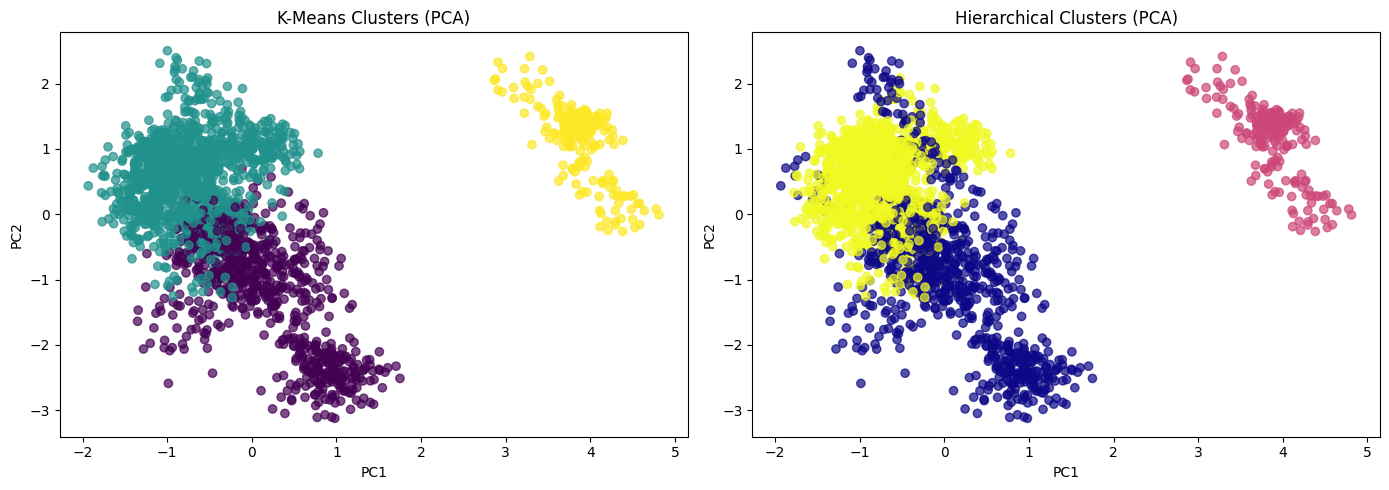

Центры кластеров K-Means (оригинальные значения):
        N        P        K  temperature  humidity     ph  rainfall
0  26.328   58.028   28.907       25.893    49.370  6.527    80.875
1  71.777   37.396   35.723       25.806    83.037  6.516   119.937
2  22.439  133.352  199.974       23.259    87.077  5.981    90.928

Средние значения по кластерам — K-Means:
                   N        P        K  temperature  humidity     ph  rainfall
KMeans_Label                                                                  
0             26.334   58.019   28.902       25.895    49.417  6.528    80.839
1             71.811   37.385   35.732       25.805    83.035  6.516   119.993
2             22.439  133.352  199.974       23.259    87.077  5.981    90.928

Средние значения по кластерам — Иерархический метод:
                         N        P        K  temperature  humidity     ph  \
Hierarchical_Label                                                           
0                   27.817   56

In [36]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols)

pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
labels_hierarchical = hierarchical.fit_predict(df_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.7)
axes[0].set_title('K-Means Clusters (PCA)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_hierarchical, cmap='plasma', alpha=0.7)
axes[1].set_title('Hierarchical Clusters (PCA)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=numeric_cols)

df_out = df_numeric.copy()
df_out['KMeans_Label'] = labels_kmeans
df_out['Hierarchical_Label'] = labels_hierarchical

print("Центры кластеров K-Means (оригинальные значения):")
print(centers_df.round(3))

print("\nСредние значения по кластерам — K-Means:")
print(df_out.groupby('KMeans_Label')[numeric_cols].mean().round(3))

print("\nСредние значения по кластерам — Иерархический метод:")
print(df_out.groupby('Hierarchical_Label')[numeric_cols].mean().round(3))

<b>Вывод: </b>K-Means выделил три кластера с разным химическим составом почвы и климатическими условиями: первый характеризуется умеренными значениями N, P, K, средней температурой и низкой влажностью; второй —- высоким азотом, умерными P и K, высокой влажностью и большим количеством осадков; третий - крайне высоким фосфором и калием при низком азоте, высокой влажности и слабокислом pH. Сравнение с иерархическим методом показывает, что обе методики выявляют схожие группы, однако K-Means точнее отражает исходные данные по агрохимическим показателям и климату, тогда как иерархический метод слегка смещает центры кластеров в сторону более высокой температуры и влажности, давая более сглаженную и обобщённую картину.
